# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 8</span>


The variational principle in Quantum Mechanics states that the expectation value of the Hamiltonian over a (good) trial quantum state has the ground state energy $E_0$ as lower bound:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

During this exercise you will variationally optimize the ground state of a single quantum particle in a one dimensional (1D) space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

This 1D quantum model is not analytically solvable and should be attacked by numerical methods. In order to obtain an approximate wave function for the ground state, the Variational Monte Carlo method uses a trial wave function, parametrized by a set of variational parameters. An approximate model for the ground state wave function is the following trial wave function:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

$\Psi_T^{\sigma,\mu}(x)$ depends on <span style="color:red">two variational parameters: $\sigma$ and $\mu$</span>.

### Exercise 08.1

Write a Variational Monte Carlo code for a single quantum particle in 1D which exploits the Metropolis algorithm to sample the square modulus of our trial wave function $|\Psi_T^{\sigma,\mu}(x)|^2$ using an uniform transition probability $T(x_{new}|x_{old})$. By using data blocking, the code should be able to compute the expectation value for the Hamiltonian

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

which can be used to find the parameters that minimize this quantity. Use $\hbar = 1$ and $m=1$.
<span style="color:red">Note that to measure $\langle {\hat H} \rangle_T$ you need the analytical calculation of:</span>
    
$$
\frac{{-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}} \Psi_T^{\sigma,\mu}(x)}{\Psi_T^{\sigma,\mu}(x)}
$$

## Introduction to the code:
To implement the Variational Monte Carlo code, I take the structure and information from the exercise `Lezione_05`, where I wrote a code for the Metropolis Algorithm. In this way, in `Esercizio_8_1`, I organize the code with a virtual class for the wave function $\Psi_T^{\sigma,\mu}(x)$ and another class called `system.h`, in which I implement the Metropolis Algorithm.

To calculate the integral of $\langle {\hat H} \rangle_T$:

- First, I sample $\rho(x)=\frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2}$ using the Metropolis Algorithm with a uniform transition probability $T(x_{\text{new}}|x_{\text{old}})$.
- Second, I evaluate the integral using the block averaging method.


To compute the integral analytically (with $\hbar = 1$ and $m = 1$), I use the following expression:
$$
\frac{{\hat H} \Psi_T(x)}{\Psi_T(x)} = \frac{(\hat{T} + \hat{V})\Psi_T(x)}{\Psi_T(x)} = \frac{{-\frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2}} \Psi_T^{\sigma,\mu}(x)}{\Psi_T^{\sigma,\mu}(x)} + V(x)
$$
$$
= \frac{1}{\Psi_T(x)} \left[ -\frac{1}{\sigma^2} + \frac{(x-\mu)^2}{\sigma^4} \right] \cdot e^{-\frac{(x-\mu)^2}{2\sigma^2}} + \left[ -\frac{1}{\sigma^2} + \frac{(x+\mu)^2}{\sigma^4} \right] \cdot e^{-\frac{(x+\mu)^2}{2\sigma^2}} + x^4 - \frac{5}{2}x^2
$$

Before calculating the integral, I use the function `initialize_acceptance(Waves\_function* WF, double coordinates)` in `system.cpp` to achieve an acceptance rate of 50\%. This ensures optimal efficiency and helps avoid correlation in the code.

Below is a portion of the code for the Metropolis Algorithm.

````cpp
    bool System::metropolis_method(Waves_function* WF) {
    
    if (WF == nullptr) {
    cerr << "Error: null WF pointer passed to initialize_acceptance!" << endl;
    return -1;
    }
    
  
    // Propose new coordinates using uniform random distribution
    double coordinate_proposed = RND.Rannyu(-1,1)*unif_delta;

    //coordinate_proposed.print("coordinate del punto proposto: ");
    
    // Calculate wave function values at current and proposed coordinates
    double x = WF->measure(get_pos_old());
    //cout << "x: " << x << endl;
    double y = WF->measure(coordinate_proposed);
    //cout << "y: " << y << endl;
    double z = RND.Rannyu(0,1); // Generate a uniform random number in [0,1]
    //out_p << x <<setw(12) <<y << endl;

    // Metropolis acceptance criteria
    if (pow(y / x, 2) >= 1.) {
        set_pos_new(coordinate_proposed); // Accept new coordinates
        //cout << "coordinate accetate" << endl;
        //out_p.close();
        return true;
    }
    else if (pow(y / x, 2) < 1. && z > pow(y / x, 2)) {
        set_pos_new(get_pos_old()); // Keep old coordinates
        //cout << "coordinate non accetate" << endl;
        //out_p.close();
        return false;
    }
    if (pow(y / x, 2) < 1. && z <= pow(y / x, 2)){
        set_pos_new(coordinate_proposed); // Accept new coordinates
        //out_p.close();
        return true;
        //cout << "coordinate accetate" << endl;
        
    }

    return false;
    
    }


````

Below, I have included the graphs obtained from the calculation of $\langle \hat{H} \rangle_T$ for different pairs of $\mu$ and $\sigma$. Subsequently, I presented a histogram of the samplings of the same pairs, comparing them with the analytical expression of the wave function.




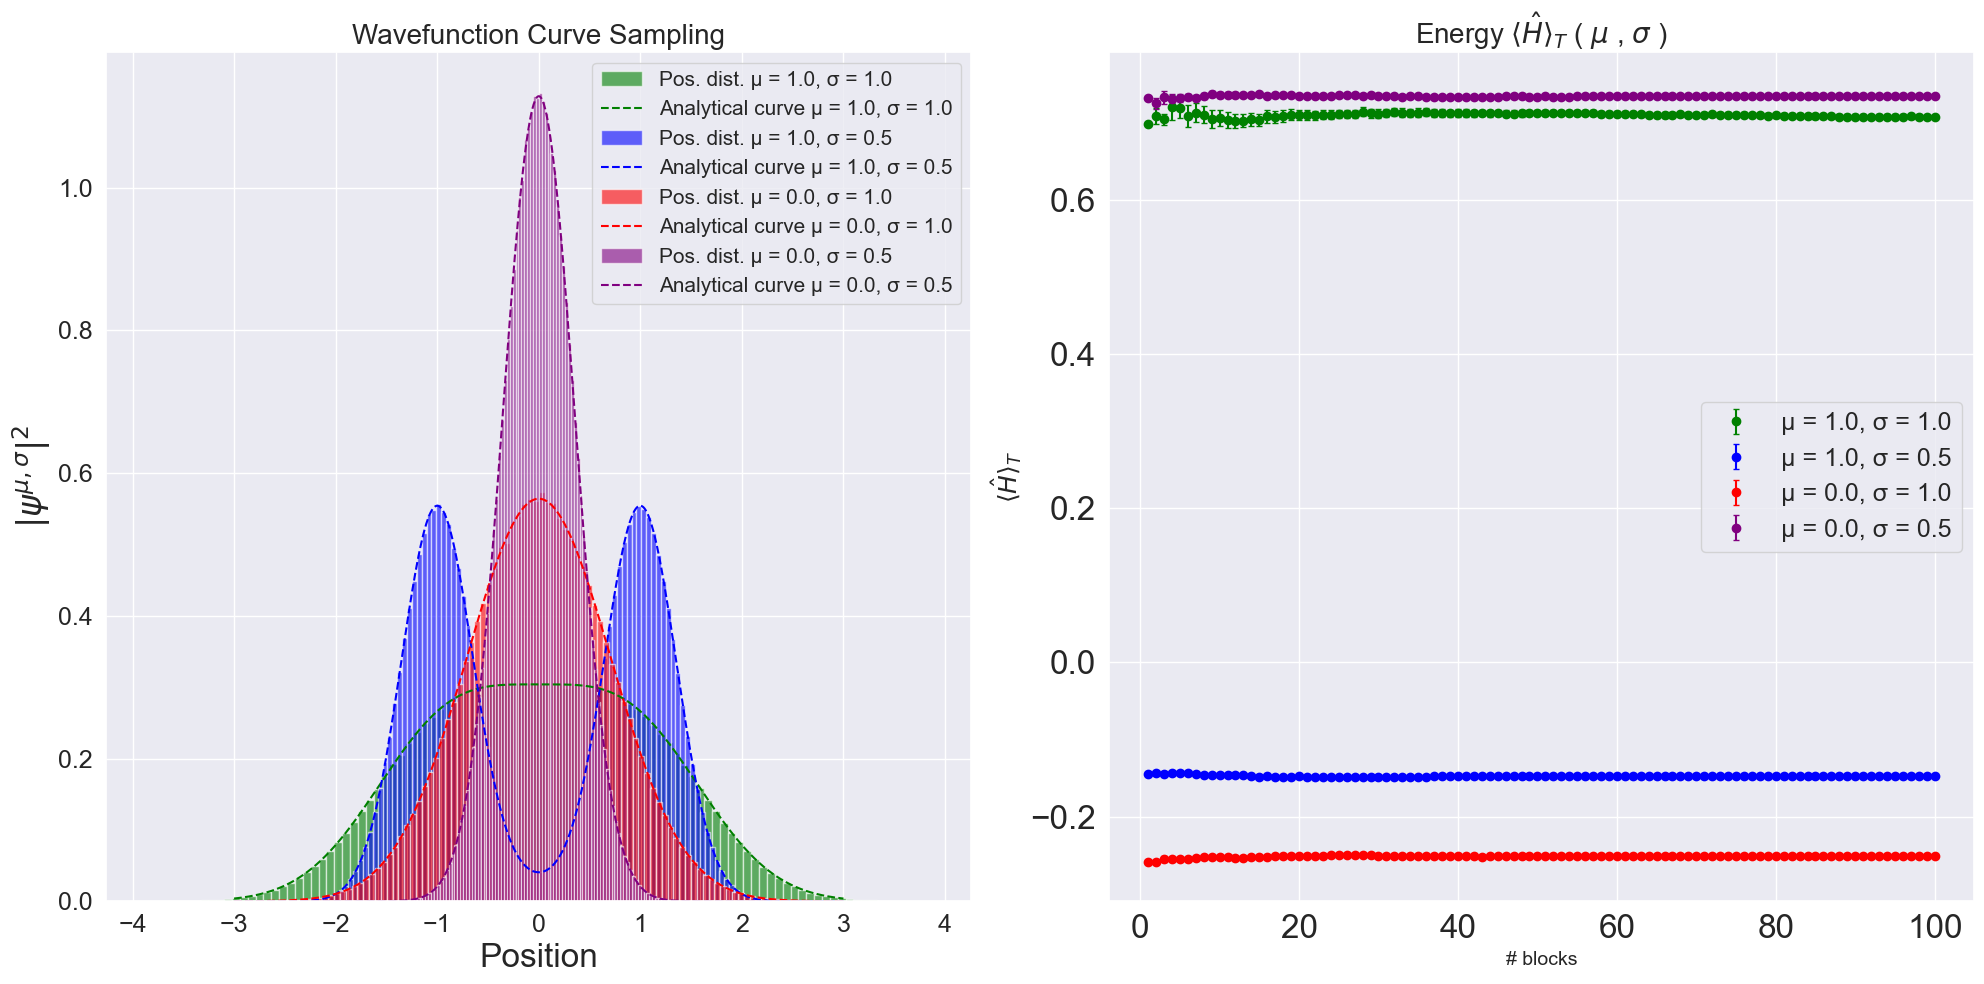

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import simps  # Importing Simpson's rule for numerical integration

sns.set_theme(style='darkgrid')

# Function to read data from file
def read_data(file_path):
    # Read the data from the file using np.loadtxt, skipping the first row
    data = np.loadtxt(file_path, skiprows=1)
    
    # Extract energy and error from the file (assuming they are in the first and second columns)
    energy = data[:, 0]   # First column: energy
    error = data[:, 1]    # Second column: error
    
    # Generate block numbers based on the number of measures (same as number of rows in data)
    blocks = np.arange(1, len(energy) + 1)  # Array from 1 to the number of measures (blocks)
    
    return blocks, energy, error

# List of (mu, sigma) pairs for different files
mu_sigma = [(1.0, 1.0), (1.0, 0.5), (0.0, 1.0), (0.0, 0.5)]
colors = ['green', 'blue', 'red', 'purple']  # Colors for different graphs

# Create a figure for the plot with two subplots
plt.figure(figsize=(20,10 ))

# First subplot for Energy
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
for i, (mu, sigma) in enumerate(mu_sigma):
    # Generate the file name corresponding to the mu, sigma pair
    file_name = f'./Esercizio_8_1/OUTPUT/Energy_ave_{mu}_{sigma}_.dat'
    
    try:
        # Try reading the data from the file
        blocks, energy, error = read_data(file_name)
        # Plot the energy with error bars
        plt.errorbar(blocks, energy, yerr=error, label=f'μ = {mu}, σ = {sigma}', color=colors[i], fmt='o', capsize=2)
    except Exception as e:
        # If an error occurs while reading the file, print an error message
        print(f"Error reading file {file_name}: {e}")

# Plot settings for Energy
plt.title(r'Energy $\langle \hat{H} \rangle_T$ ( $\mu$ , $\sigma$ ) ', fontsize=20)
plt.xlabel('# blocks', fontsize=14)
plt.ylabel(r'$\langle \hat{H} \rangle_T$', fontsize=18)
plt.legend(fontsize =18)  # Display the legend with labels for each plot
plt.grid(True)  # Add grid lines to the plot
plt.xticks(fontsize=24)  
plt.yticks(fontsize=24)  

def mod_wf(x, _mu, _sigma):
    return (np.exp(-(x - _mu)**2 / (2 * _sigma**2)) + np.exp(-(x + _mu)**2 / (2 * _sigma**2)))**2

# Second subplot for Wavefunction
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
mu_sigma = [(1.0, 1.0), (1.0, 0.5), (0.0, 1.0), (0.0, 0.5)]
for i, (mu, sigma) in enumerate(mu_sigma):
    # Generate the file name for the wavefunction file
    file_name = f'./Esercizio_8_1/OUTPUT/WaveFunction_{mu}_{sigma}_.dat'
    
    try:
        # Read the data (positions)
        positions = np.loadtxt(file_name, skiprows=1)
        
        # Plot histogram of positions
        plt.hist(positions, bins=100, density=True, alpha=0.6, color=colors[i], label=f'Pos. dist. μ = {mu}, σ = {sigma}')
        
        # Generate x values for the wavefunction curve (assuming x is from -3 to 3 for a good representation)
        x_vals = np.linspace(-3, 3, 1000)
        
        # Compute modulated wavefunction
        wf_vals = mod_wf(x_vals, mu, sigma)
        
        # Normalize the wavefunction to match the histogram's normalization
        norm_factor = simps(wf_vals, x_vals)  # Integrating the wavefunction to get its area
        wf_vals_normalized = wf_vals / norm_factor  # Normalize the wavefunction
        
        
        # Plot the normalized wavefunction curve
        plt.plot(x_vals, wf_vals_normalized, color=colors[i], linestyle='--', label=f'Analytical curve μ = {mu}, σ = {sigma}')
    
    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

# Plot settings for Wavefunction
plt.title('Wavefunction Curve Sampling', fontsize=20)
plt.xlabel('Position', fontsize=24)
plt.ylabel(r'$|\psi^{ \mu,\sigma}|^2$', fontsize=24)
plt.legend(fontsize = 15)  # Display the legend with labels for each plot
plt.grid(True)  # Add grid lines to the plot
plt.xticks(fontsize=18)  
plt.yticks(fontsize=18)  

# Show the plot with both subplots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot


The obtained graphs of of sampled $\Psi_T^{\mu, \sigma}$ seem to reflect the expected value obtained analytically.

While, for the best parameters to evaluate the Ground state it is used `simulated annealing algorithm` utilized in `Esercizio_8_2`.

### Exercise 08.2

To find the parameters $\sigma$ and $\mu$ which minimize $\langle {\hat H} \rangle_T$, extend your Variational Monte Carlo code to face the variational optimization problem via a <span style="color:red">Simulated Annealing (SA) algorithm</span>.

Choose an appropriate starting temperature for your SA algorithm and an appropriate temperature-update-law to make the optimization work.

Compute $\langle {\hat H} \rangle_T$ with enough statistics in order to be able to measure the lowering of $\langle {\hat H} \rangle_T$ once the variational parameters are moved.

### Simulated Annealing Algorthm
Simulated Annealing (SA) is a technique used to find the optimal parameters of a system by minimizing the loss function  L(x), where x represents the vector of parameters (e.g., $\mu$ and $\sigma$) . The idea is to interpret  L(x) as the energy of a statistical system and sample configurations using the Boltzmann distribution: $p(x) = \frac{\exp[-\beta L(x)]}{Z}$

In the limit  $\beta \rightarrow \infty $ (i.e., as the temperature approaches zero), the distribution concentrates on the minima of L(x), corresponding to the optimal parameters.

The annealing process involves a schedule of inverse temperatures  $\{\beta_1, \beta_2, ..., \beta_N\}$ and Monte Carlo steps  $\{n_1, n_2, ..., n_N\}$ at each temperature. Starting from an initial configuration  $x_0$, the algorithm performs  $n_1$ steps at temperature  $T_1 = 1/\beta_1$, then  $n_2$ steps at $T_2 = 1/\beta_2$, and so on. The final configuration at each stage is used as the starting point for the next stage.

The essence of SA is the slow cooling process, allowing the system to explore various configurations and ultimately settle into a low-energy state, ideally reaching the global minimum.

### Introduction to the code:
The code is based on the exercise `Esercizio_8_1`, with the addition of the simulated annealing algorithm:
- The program starts with an initial temperature $ T_{start} = 2 $ and ends when the temperature reaches $T < 0.01$.
- The choice of the parameter $\delta$ for metropolis acceptance is explained in the next paragraph;
- Before cooling the system, the code calculates the expectation value of the Hamiltonian $\langle \hat{H} \rangle_T $ ten times. After each estimation, the energy is compared with the previous one using the `Boltzmann` function, which applies the Boltzmann distribution to accept the result, using Metropolis Algorithm.

````cpp
    bool System:: Boltzmann(double temp, double Energy_old , double Energy_new){
        double _beta = 1./temp;
        double z = RND.Rannyu(0,1);
        double boltz = exp(-1.*(Energy_new-Energy_old)*_beta);

        if(boltz >= 1.){return true;
        }else{
            if(z < boltz){return true;
            }else{return false;}
        }
        return false;
};

````
- The best energy value, along with the corresponding parameters $\mu$ and $\sigma$, is set for the next stage.
- The system is cooled by multiplying the current temperature by a factor of $0.998 $ using the `cooling()}` function in `system.cpp`.
- After each stage, $\mu$ and $\sigma$ are updated randomly. This is done by taking respectively the last values of  $\mu $ and $\sigma$ found and adding a random value between $ [-1 ,1) $, multiplied by a numerical factor dependent on the temperature. As the temperature decreases, the search for parameters becomes more constrained.
- At the end of the process, the best overall values of energy, $\mu$ and $\sigma$ are recorded comparing with the last best values recorded.


The main part of the program is shown below:

````cpp
// Begin the annealing schedule
while (sys.get_temp() > 0.01) {
    
    // Loop for 10 iterations to calculate energy
    while (contatore <= 10) {
        cout << "Cycle number: " << contatore << endl;     
        vector<double> energy(N_block, 0.0);  // Store energy per block
        vector<double> energy_2(N_block, 0.0);  // Store squared energy per block

        // Set delta for Metropolis algorithm
        sys.set_delta(sys.WVT->get_mu() + 3 * sys.WVT->get_sigma());

       [...] Metropolis algorithm for energy <H>;

        // Perform block averaging and write results to energy file
        Bloch_mean_method(energy, energy_2, N_block, en_ave_new, en_err_new);

        // Calculate acceptance using the Boltzmann distribution
        accept = sys.Boltzmann(sys.get_temp(), sys.get_energy_old(), en_ave_new);

        // If accepted, update energy and best parameters
        if (accept == true) {
            sys.set_energy_new(en_ave_new);
            sys.set_err_new(en_err_new);
            pos_x_in = 0.0;
            mu_best = sys.HT->get_mu();
            sigma_best = sys.HT->get_sigma();

            cout << "Accepted step!" << endl << "Temperature: " << sys.get_temp() << "  Energy: " << en_ave_new << " Error: " << en_err_new << endl;
        }
        // If not accepted, revert to the best parameters
        if (accept == false) {
            sys.HT->set_mu(mu_best);
            sys.HT->set_sigma(sigma_best);
            sys.set_energy_new(sys.get_energy_old());

            cout << "Rejected step!" << endl << "Temperature: " << sys.get_temp() << "  Energy: " << sys.get_energy_old() << " Error: " << sys.get_err_old() << endl;
        }
        
        // Update mu and sigma with a random adjustment
        sys.WVT->set_mu(abs(sys.WVT->get_mu() + sys.get_temp() * sys.RND.Rannyu(-1, 1) * 0.5));
        sys.WVT->set_sigma(abs(sys.WVT->get_sigma() + sys.get_temp() * sys.RND.Rannyu(-1, 1) * 0.25));
        contatore++;  // Increment the counter
        pos_x_in = 0;  // Reset position variable
    }
    
    // Cool the system
    sys.cooling();
    contatore = 1;  // Reset counter for the next temperature stage

    // Check if the current energy is the best
    if (sys.get_energy_old() < en_t) {
        en_t = sys.get_energy_old();  // Update best energy
        mu_t = sys.WVT->get_mu();     // Update best mu
        s_t = sys.WVT->get_sigma();    // Update best sigma
    }
}

cout << "Annealing finished!!" << endl;


````

In this way I obtained three files for averaged Energy,`./OUTPUT/Energy_ave.dat`, mu and sigma `./OUTPUT/mu_sigma.dat` and best parameters `./OUTPUT/Best_measure.dat`


### Correction of Acceptance calculation

During the execution of the algorithm, I noticed that we were measuring energy values well below those expected for Gaussian functions with $\mu$ values greater than 2 and $\sigma$ values less than 1, compared to those expected from the calculation obtained by transforming the Schrödinger equation into a matrix equation. The reason was that the function `initialize_acceptance()` was unable to find the 50\% acceptance for the Metropolis method. At least, it could only find it in regions where there was low overlap of the tails of the two wavefunction,as shown in example the subsequent graph.

To address this situation, I had to sacrifice the efficiency of the Metropolis method by imposing the sampling delta equal to the value $\delta=(\mu + 3\sigma)$, so that the sampling would take place over the entire wave function and not just in the central part, 


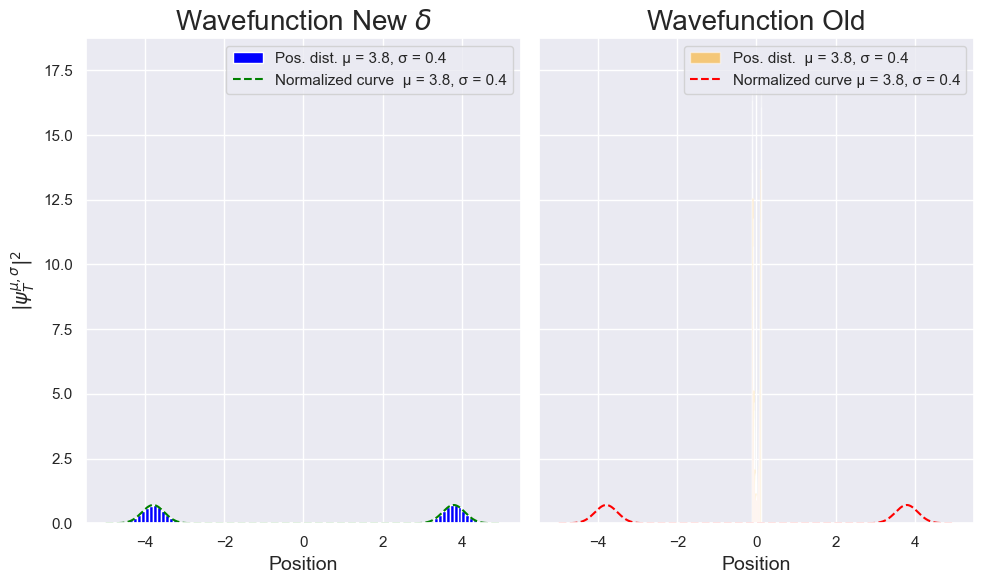

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import simps  # Importing Simpson's rule for numerical integration

sns.set_theme(style='darkgrid')

# Function to compute the modulated wavefunction
def mod_wf(x, _mu, _sigma):
    return (np.exp(-(x-_mu)**2/(2*_sigma**2)) + np.exp(-(x+_mu)**2/(2*_sigma**2)))**2

# List of (mu, sigma) pairs
mu_sigma = [(3.8, 0.4)]
colors = ['green', 'blue', 'red', 'purple']  # Colors for different graphs

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

for i, (mu, sigma) in enumerate(mu_sigma):
    # File paths for the wavefunction files
    file_name_new = f'./Esercizio_8_1/OUTPUT/WaveFunction_{mu}_{sigma}_.dat'
    file_name_old = f'./Esercizio_8_1/OUTPUT/WaveFunction_{mu}_{sigma}_old.dat'
    
    # Read new data
    try:
        positions_new = np.loadtxt(file_name_new, skiprows=1)
        axs[0].hist(positions_new, bins=100, density=True, alpha=1, color='blue', label=f'Pos. dist. μ = {mu}, σ = {sigma}')
        
        # Generate x values for the wavefunction curve
        x_vals = np.linspace(-5, 5, 1000)
        
        # Compute modulated wavefunction
        wf_vals_new = mod_wf(x_vals, mu, sigma)
        
        # Normalize the wavefunction
        norm_factor_new = simps(wf_vals_new, x_vals)
        wf_vals_normalized_new = wf_vals_new / norm_factor_new
        
        # Plot the normalized wavefunction curve
        axs[0].plot(x_vals, wf_vals_normalized_new, color=colors[i], linestyle='--', label=f'Normalized curve  μ = {mu}, σ = {sigma}')
        
    except Exception as e:
        print(f"Error reading file {file_name_new}: {e}")

    # Read old data
    try:
        positions_old = np.loadtxt(file_name_old, skiprows=1)
        axs[1].hist(positions_old, bins=100, density=True, alpha=0.5, color='orange', label=f'Pos. dist.  μ = {mu}, σ = {sigma}')
        
        
        wf_vals_old = mod_wf(x_vals, mu, sigma)  # Reusing the same function
        norm_factor_old = simps(wf_vals_old, x_vals)
        wf_vals_normalized_old = wf_vals_old / norm_factor_old
        
        # Plot the normalized old wavefunction curve
        axs[1].plot(x_vals, wf_vals_normalized_old, color='red', linestyle='--', label=f'Normalized curve μ = {mu}, σ = {sigma}')
    
    except Exception as e:
        print(f"Error reading file {file_name_old}: {e}")

# Plot settings for the first subplot (New)
axs[0].set_title(r'Wavefunction New $\delta$', fontsize=20)
axs[0].set_xlabel('Position', fontsize=14)
axs[0].set_ylabel(r'$|\psi^{ \mu,\sigma}_T|^2$', fontsize=14)
axs[0].legend()  # Display the legend for the first subplot
axs[0].grid(True)  # Add grid lines

# Plot settings for the second subplot (Old)
axs[1].set_title('Wavefunction Old', fontsize=20)
axs[1].set_xlabel('Position', fontsize=14)
axs[1].legend()  # Display the legend for the second subplot
axs[1].grid(True)  # Add grid lines

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot



It is evident that the new method for calculating $\delta$ for the acceptance in the Metropolis algorithm is more efficient than the old one, in which the program reaches 50% in a tail region of the wavefunction, incorrectly sampling the obtained wavefunction.

### Observation to the effiency of the program:
One of the data analyzed in this program came from a run lasting approximately 4 hours. This long runtime is due to the slow cooling rate, with the temperature decreasing by only 0.2‰ per step, resulting in a large number of calculations for each temperature. The running time could be significantly reduced by increasing the cooling factor (e.g., to 1%) and reducing the number of calculations. 
To show that the result remains unchanged even with these parameters, I have decided to present a comparison between these data (which we will call **Very Slow Cool (VSC)**) and data obtained with a faster process, with a cooling factor equal to 1% of the temperature and a number of 3 integrals (instead of 10) at a fixed temperature, which we will call **Slow Cool (SC)**.


- <span style="color:red">Show a picture of $\langle {\hat H} \rangle_T$ (with statistical uncertainties) as a function of the SA steps of the algorithm</span>


Minimum Energy: -0.444594
Index of Minimum Energy: 2314
Minimum Energy: -0.444453
Index of Minimum Energy: 452


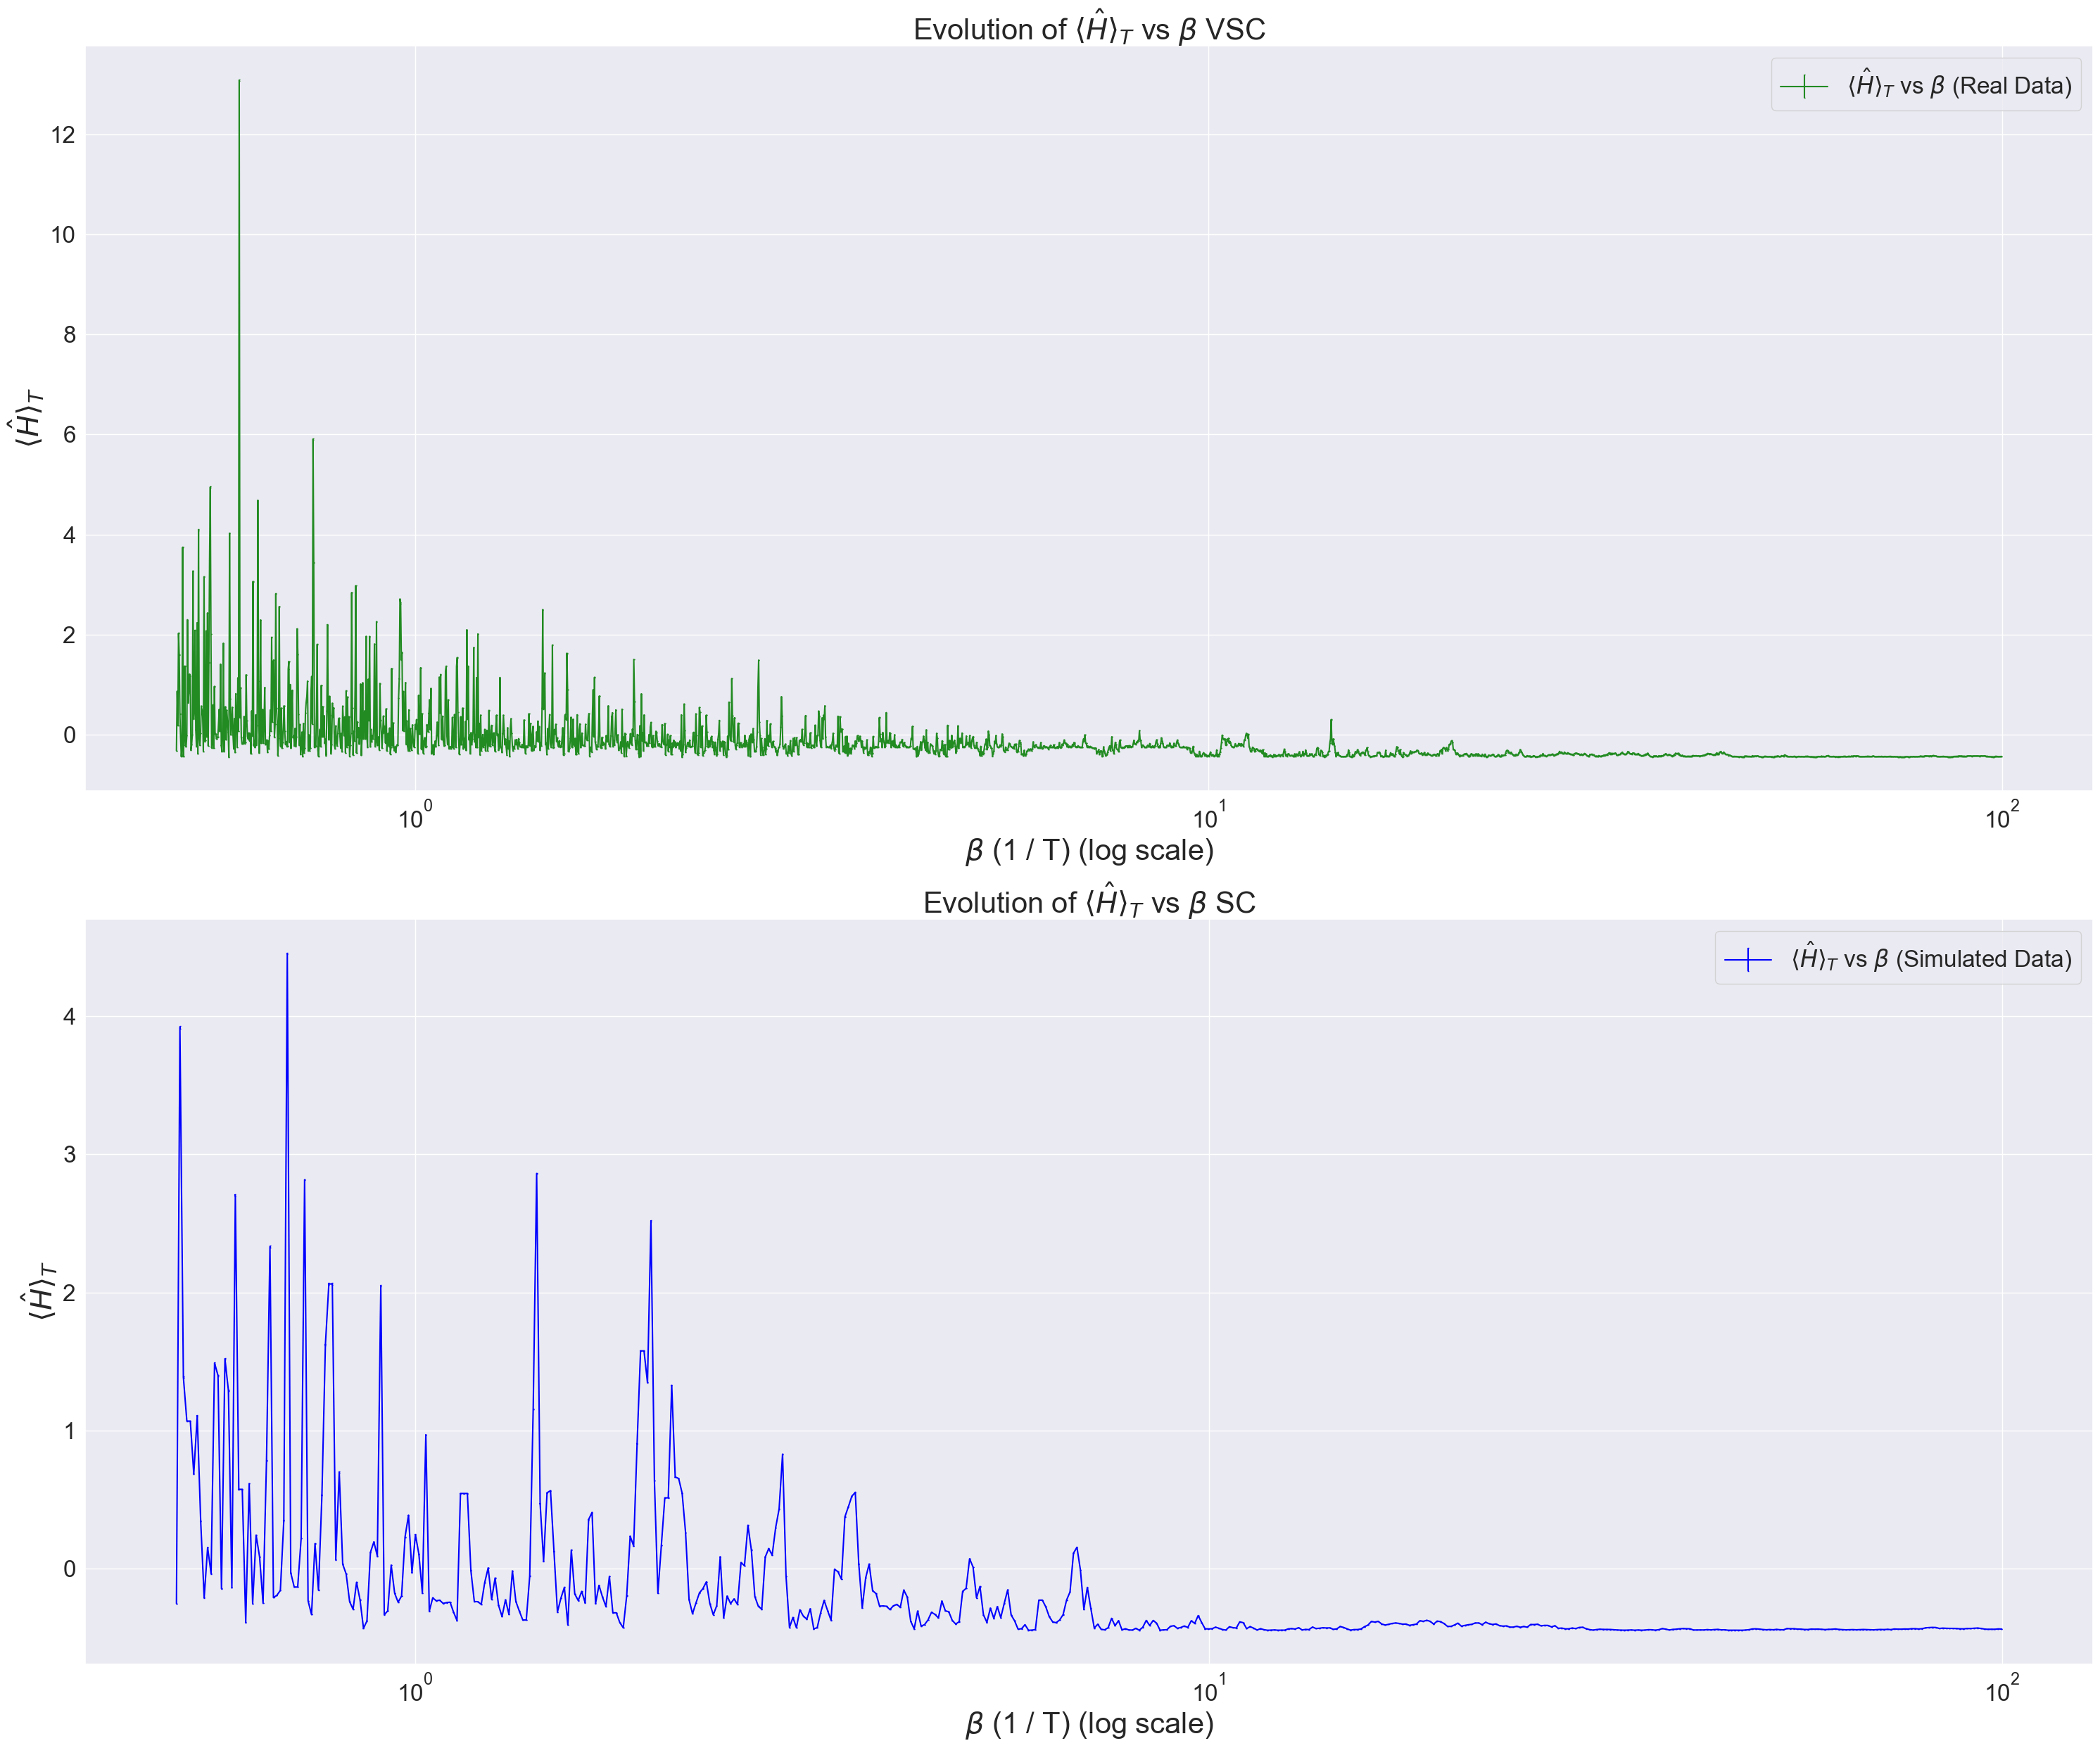

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

# Function to read data from file
def read_data(file_path):
    data = np.loadtxt(file_path, skiprows=1)  # Read data
    temperature = data[:, 0]  # First column: temperature
    energy = data[:, 1]       # Second column: energy
    error = data[:, 2]        # Third column: error
    energy_min = np.min(energy)
    energy_min_index = np.argmin(energy)

    print(f"Minimum Energy: {energy_min}")
    print(f"Index of Minimum Energy: {energy_min_index}")
    
    return temperature, energy, error, energy_min_index

# Define the file names and color
file_name_real = './Esercizio_8_2/OUTPUT_real/Energy_ave.dat'
file_name_sim = './Esercizio_8_2/OUTPUT/Energy_ave.dat'


# Create a single figure with figsize=(30, 10)
fig, axs = plt.subplots(2, 1, figsize=(30, 25))  

# First subplot
try:
    # Reading the data from the first file
    temperature, energy, error, idx = read_data(file_name_real)
    
    # Plot the energy with error bars (beta = 1/temperature)
    axs[0].errorbar(1.0 / temperature, energy, yerr=error, color='forestgreen', fmt='-', capsize=1, 
                    label=r'$\langle \hat{H} \rangle_T$ vs $\beta$ (Real Data)')
    
except Exception as e:
    print(f"Error reading file {file_name_real}: {e}")

# Customize the first subplot
axs[0].set_xscale('log')
axs[0].set_title(r'Evolution of $\langle \hat{H} \rangle_T$ vs $\beta$ VSC', fontsize=30)
axs[0].set_xlabel(r'$\beta$ (1 / T) (log scale)', fontsize=30)
axs[0].set_ylabel(r'$\langle \hat{H} \rangle_T$', fontsize=30)
axs[0].legend(loc='upper right', fontsize=24)
axs[0].tick_params(axis='both', labelsize=24)
axs[0].grid(True)

# Second subplot
try:
    # Reading the data from the second file
    temperature, energy, error, idx = read_data(file_name_sim)
    
    # Plot the energy with error bars (beta = 1/temperature)
    axs[1].errorbar(1.0 / temperature, energy, yerr=error, color='blue', fmt='-', capsize=1, 
                    label=r'$\langle \hat{H} \rangle_T$ vs $\beta$ (Simulated Data)')
    
except Exception as e:
    print(f"Error reading file {file_name_sim}: {e}")

# Customize the second subplot
axs[1].set_xscale('log')
axs[1].set_title(r'Evolution of $\langle \hat{H} \rangle_T$ vs $\beta$ SC', fontsize=30)
axs[1].set_xlabel(r'$\beta$ (1 / T) (log scale)', fontsize=30)
axs[1].set_ylabel(r'$\langle \hat{H} \rangle_T$', fontsize=30)
axs[1].legend(loc='upper right', fontsize=24)
axs[1].tick_params(axis='both', labelsize=24)
axs[1].grid(True)

# Show the plot
plt.tight_layout()
plt.show()


Here, it is possible to see how each simulations converges to a valued   that we assumed to be the ground state.

- you could also show a picture of the trajectory of the SA algorithm in the variational parameter space as a function of the SA steps


Minimum Energy: -0.444594
Index of Minimum Energy: 2314
Minimum Energy: -0.444453
Index of Minimum Energy: 452


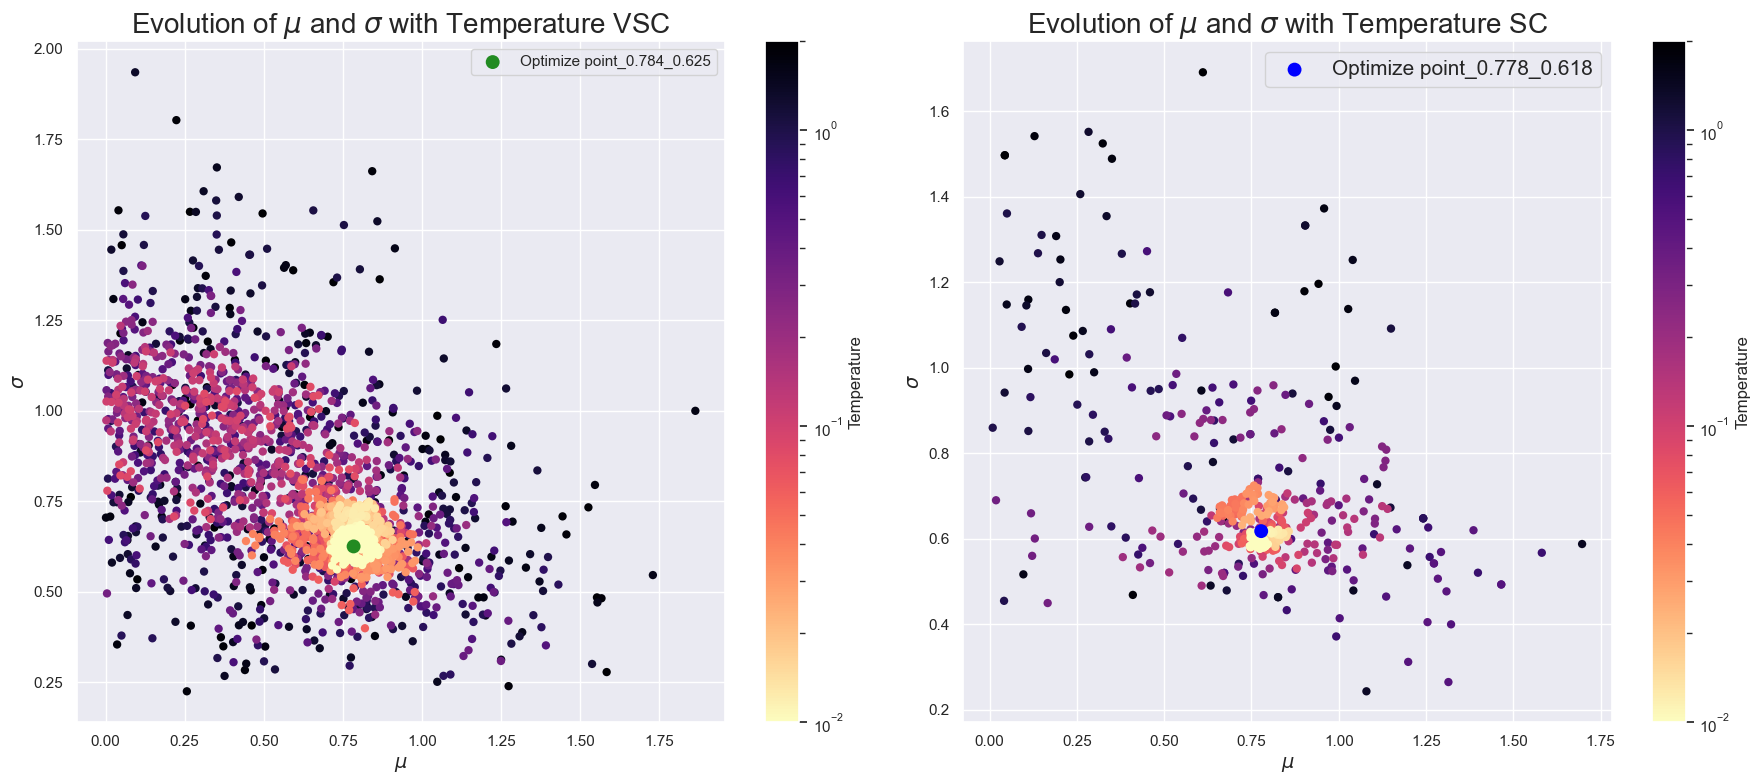

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.colors import LogNorm  # Importare LogNorm

# Set the theme
sns.set_theme(style='darkgrid')

# Create a single figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(18, 8))  # Larger width, reasonable height for both plots

# Load the first dataset using numpy's loadtxt (assuming space-separated values)
data = np.loadtxt('./Esercizio_8_2/OUTPUT_real/mu_sigma.dat', skiprows=1)
temperature, energy, error, idx_min = read_data('./Esercizio_8_2/OUTPUT_real/Energy_ave.dat')

mu = data[:, 1]           # Second column: mu
sigma = data[:, 2]        # Third column: sigma
norm_temp = (temperature - temperature.min())  # Normalize temperature for the colormap

# First subplot (axs[0])
cmap = cm.magma_r
sc0 = axs[0].scatter(mu, sigma, c=norm_temp, cmap=cmap, norm=LogNorm(vmin=0.01, vmax=2), edgecolor='none')

# Mark the optimized point
axs[0].scatter(mu[idx_min+1], sigma[idx_min+1], color='forestgreen', edgecolor='none', 
               label=f'Optimize point_{mu[idx_min+1]:.3g}_{sigma[idx_min+1]:.3g}', s=100)

# Add colorbar with log scale
cbar0 = plt.colorbar(sc0, ax=axs[0])
cbar0.set_label('Temperature')

# Add labels and title to the first plot
axs[0].set_xlabel(r'$\mu$', fontsize=14)
axs[0].set_ylabel(r'$\sigma$', fontsize=14)
axs[0].set_title(r'Evolution of $\mu$ and $\sigma$ with Temperature VSC', fontsize=20)
axs[0].legend()
axs[0].grid(True)

# Load the second dataset
data = np.loadtxt('./Esercizio_8_2/OUTPUT/mu_sigma.dat', skiprows=1)
temperature, energy, error, idx_min = read_data('./Esercizio_8_2/OUTPUT/Energy_ave.dat')

mu = data[:, 1]           # Second column: mu
sigma = data[:, 2]        # Third column: sigma
norm_temp = (temperature - temperature.min())  # Normalize temperature for the colormap

# Second subplot (axs[1])
sc1 = axs[1].scatter(mu, sigma, c=norm_temp, cmap=cmap, norm=LogNorm(vmin=0.01, vmax=2), edgecolor='none')

# Mark the optimized point
axs[1].scatter(mu[idx_min+1], sigma[idx_min+1], color='blue', edgecolor='none', 
               label=f'Optimize point_{mu[idx_min+1]:.3g}_{sigma[idx_min+1]:.3g}', s=100)

# Add colorbar with log scale
cbar1 = plt.colorbar(sc1, ax=axs[1])
cbar1.set_label('Temperature')

# Add labels and title to the second plot
axs[1].set_xlabel(r'$\mu$', fontsize=14)
axs[1].set_ylabel(r'$\sigma$', fontsize=14)
axs[1].set_title(r'Evolution of $\mu$ and $\sigma$ with Temperature SC', fontsize=20)
axs[1].legend(fontsize=15)
axs[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In this graphics, it is possible to see how, as the temperature decreases, the mapped values of $\sigma(0,2)$ and $\mu(0,2)$ tend to concentrate in a region until reaching the optimization point. It is not necessarily the case that the optimization point is the last one in the simulation, as the system continues to propose values of $\mu$ and $\sigma$ that can be accepted using the Metropolis method with the Boltzmann distribution as a weight. However, it is evident that the optimized point is within the densest region of sampled points.
For each plot there is the convergence in one point, that have similar coordinate. 


- <span style="color:red">show a picture of the estimation of $\langle {\hat H} \rangle_T$ </span> and its statistical uncertainty as a function of the number of blocks/MC steps <span style="color:red">for the set of parameters which minimize $\langle {\hat H} \rangle_T$</span>


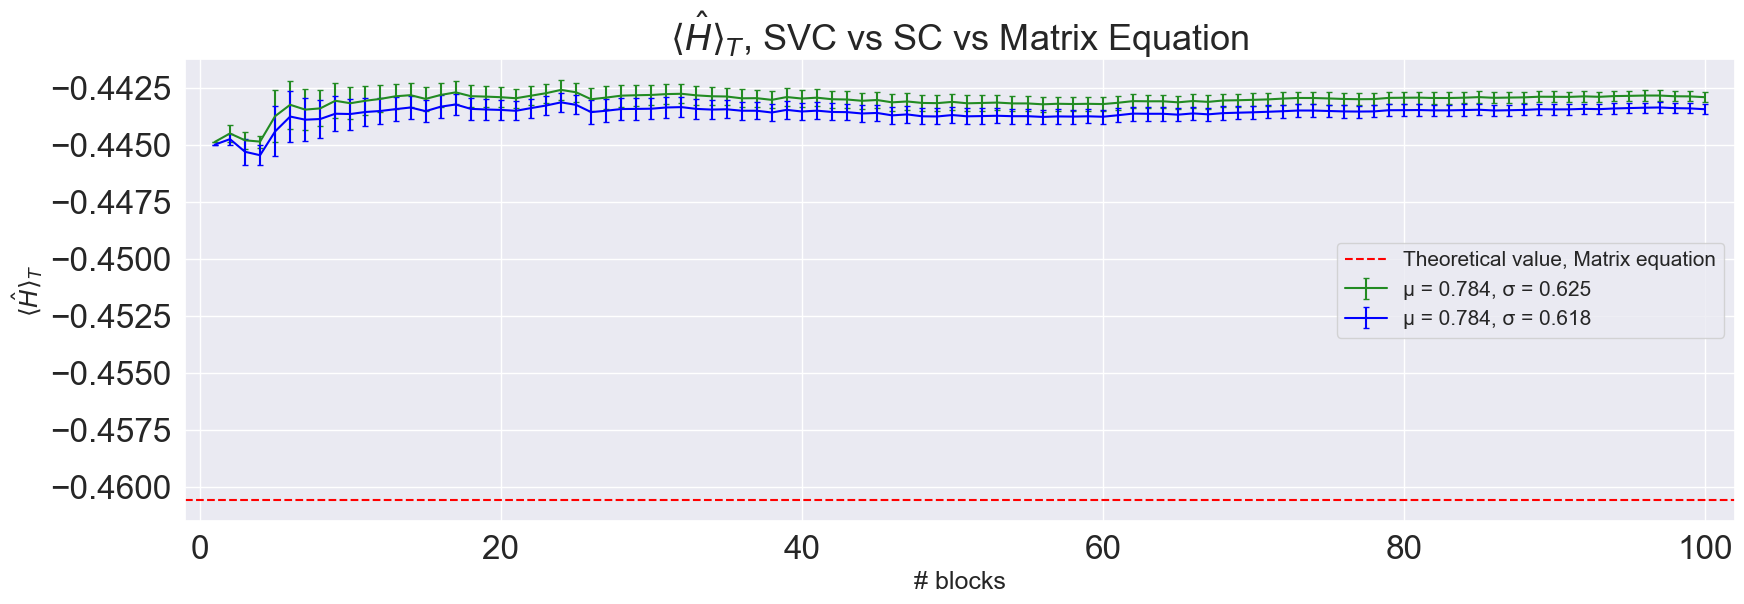

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

# Function to read data from file
def read_data(file_path):
    # Read the data from the file using np.loadtxt, skipping the first row
    data = np.loadtxt(file_path, skiprows=1)
    
    # Extract energy and error from the file (assuming they are in the first and second columns)
    energy = data[:, 0]   # First column: energy
    error = data[:, 1]    # Second column: error
    
    # Generate block numbers based on the number of measures (same as number of rows in data)
    blocks = np.arange(1, len(energy) + 1)  # Array from 1 to the number of measures (blocks)
    
    return blocks, energy, error

# List of (mu, sigma) pairs for different files
mu_sigma = [(0.784, 0.625),(0.784, 0.618)]
colors = ['forestgreen','blue']  # Colors for different graphs

# Create a figure for the plot
plt.figure(figsize=(20, 6))

# Loop over the (mu, sigma) pairs to generate the plot for each file
for i, (mu, sigma) in enumerate(mu_sigma):
    # Generate the file name corresponding to the mu, sigma pair
    file_name = f'./Esercizio_8_1/OUTPUT/Energy_ave_{mu}_{sigma}_.dat'
    
    try:
        # Try reading the data from the file
        blocks, energy, error = read_data(file_name)
        # Plot the energy with error bars
        plt.errorbar(blocks, energy, yerr=error, label=f'μ = {mu}, σ = {sigma}', color=colors[i], fmt='-', capsize=2)
    except Exception as e:
        # If an error occurs while reading the file, print an error message
        print(f"Error reading file {file_name}: {e}")

# Add the horizontal line for the theoretical value
plt.axhline(y=-0.4606, label='Theoretical value, Matrix equation', color='red', linestyle='--')

# Set limits for the x-axis and y-axis (adjust the values as needed)
plt.xlim(-1, 102)  # Example: limit x-axis between 0 and 100 blocks

plt.xticks(fontsize=24)  
plt.yticks(fontsize=24)

# Plot settings
plt.title(r'$\langle \hat{H}\rangle _T$, SVC vs SC vs Matrix Equation', fontsize=26)
plt.xlabel('# blocks', fontsize=18)
plt.ylabel(r'$\langle \hat{H} \rangle_T$', fontsize=18)
plt.legend(fontsize =15)  # Display the legend with labels for each plot
plt.grid(True)  # Add grid lines to the plot
plt.show()  # Display the plot


The systems converge to a ground state values not identical respect of the ground state of Matrix Equation. Probably, there is a systematic error in the program such that the matrix value of the equation and the expected value do not converge to the same value.

- <span style="color:red">show also a picture **of the sampled** $|\Psi_T(x)|^2$</span> by filling a histogram with the sampled configurations, moreover compare it with the analytic curve of $|\Psi_T(x)|^2$ and with the numerical solution obtained by transforming the Schrodinger equation into a matrix equation (see below the supplementary material).

### <span style="color:green">Supplementary material</span>

How can we describe a wave function as a vector? We set up a lattice of discrete points, spaced by a constant distance $dx$, and record the value of the function at each lattice point. In this way the wave function, $\Psi(x)$ become a vector:

$$
\Psi(x) \to \left[ \Psi(x_1), \Psi(x_2), ..., \Psi(x_N) \right] = 
\left[ \Psi_1, \Psi_2, ..., \Psi_N \right]
$$

The time independent Schrodinger equation 

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

can be written in matrix form. But how do we write the second derivative at a particular point? Let's start with the first derivatives:
$$
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) \simeq \frac{\Psi_{i+1}-\Psi_{i}}{dx}\\
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right) \simeq \frac{\Psi_{i}-\Psi_{i-1}}{dx}
$$

Thus, we can discretize the second derivative in the following way:
$$
\frac{\partial^2}{\partial x^2} \Psi(x=x_i) =
\frac{\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) - \frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right)}{dx} =
\frac{\Psi_{i+1}-2\Psi_{i}+\Psi_{i-1}}{dx^2}
$$

We finally obtain:

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

To solve the time independent Schrodinger equation we therefore have to find eigenstates and eigenvalues of the matrix just obtained.

Ground state energy:  -0.4604658796923901
1st excited state energy:  0.09742471331806084
2nd excited state energy:  1.9717331343935816


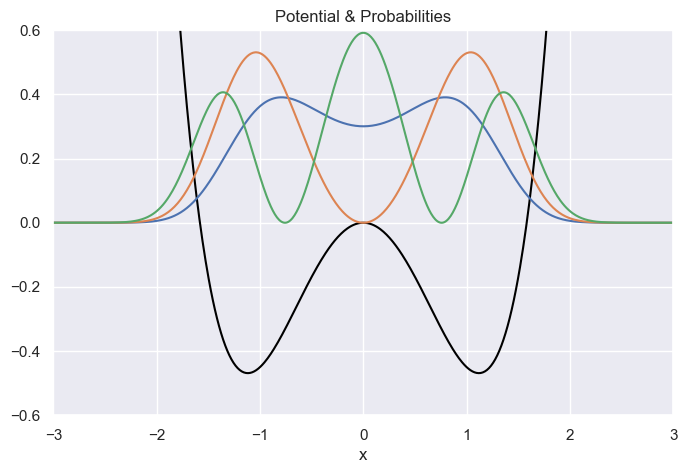

In [24]:
import numpy as np
import matplotlib.pyplot as plt
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)
# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])


print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

# Plot a few things
plt.figure(figsize=(8,5))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(psi[0])**2)
plt.plot(x,(psi[1])**2)
plt.plot(x,(psi[2])**2)
plt.title("Potential & Probabilities")
plt.xlabel("x")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.show()

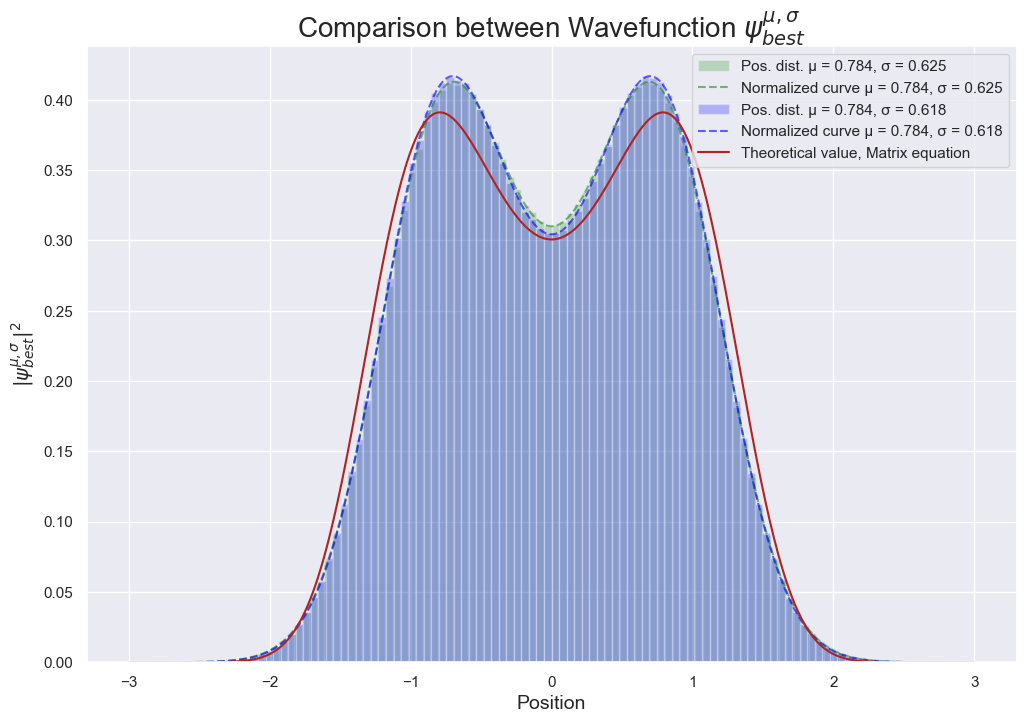

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import simps  # Importing Simpson's rule for numerical integration

sns.set_theme(style='darkgrid')

def Vpot(x):
    return (x**2 - 2.5)*x**2

hbar = 1
m = 1
a = 10
N = 1000  # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0]  # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2
CDiff = np.diag(np.ones(N-1), -1) - 2 * np.diag(np.ones(N), 0) + np.diag(np.ones(N-1), 1)

# Hamiltonian matrix
H = (-(hbar**2) * CDiff) / (2 * m * dx**2) + np.diag(V)
# Compute eigenvectors and their eigenvalues
E, psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi / np.sqrt(dx)

# Function to compute the modulated wavefunction
def mod_wf(x, _mu, _sigma):
    return (np.exp(-(x - _mu)**2 / (2 * _sigma**2)) + np.exp(-(x + _mu)**2 / (2 * _sigma**2)))**2

# List of (mu, sigma) pairs
mu_sigma = [(0.784, 0.625),(0.784, 0.618)]
colors = ['forestgreen', 'blue']

# Plotting the histogram and wavefunction for each (mu, sigma) pair
plt.figure(figsize=(12, 8))

for i, (mu, sigma) in enumerate(mu_sigma):
    # Generate the file name for the wavefunction file
    file_name = f'./Esercizio_8_1/OUTPUT/WaveFunction_{mu}_{sigma}_.dat'
    
    try:
        # Read the data (positions)
        positions = np.loadtxt(file_name, skiprows=1)

        # Define new range for x values
        x_vals = np.linspace(-3, 3, 1000)  # Adjusted range
        # Plot histogram of positions within the new range
        plt.hist(positions, bins=100, density=True, alpha=0.25, color=colors[i], label=f'Pos. dist. μ = {mu}, σ = {sigma}')

        # Compute modulated wavefunction
        wf_vals = mod_wf(x_vals, mu, sigma)

        # Normalize the wavefunction to match the histogram's normalization
        norm_factor = simps(wf_vals, x_vals)  # Integrating the wavefunction to get its area
        wf_vals_normalized = wf_vals / norm_factor  # Normalize the wavefunction

        # Plot the normalized wavefunction curve
        plt.plot(x_vals, wf_vals_normalized, color=colors[i], linestyle='--',alpha = 0.6, label=f'Normalized curve μ = {mu}, σ = {sigma}')
        
        # Get the matrix equation wave function values in the same range
        idx = np.where((x >= -3) & (x <= 3))  # Get indices for the reduced range
        

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")
plt.plot(x[idx], (psi[0][idx])**2, label=f'Theoretical value, Matrix equation', markersize=6, color='firebrick')

# Plot settings
plt.title(r'Comparison between Wavefunction $\psi^{\mu,\sigma}_{best}$', fontsize=20)
plt.xlabel('Position', fontsize=14)
plt.ylabel(r'$|\psi^{ \mu,\sigma}_{best}|^2$', fontsize=14)
plt.legend()  # Display the legend with labels for each plot
plt.grid(True)  # Add grid lines to the plot
plt.show()  # Display the plot


Here, it is also possible to compare the sampling of the wave function with the analytical (normalized) solution and the values obtained from the matrix equation. Clearly, there is a systematic error, as even when using the optimal pair of $\mu$ and $\sigma$ the calculations do not align. However also the matrix equation comes from an approximation of the derivation of the wavefunction. 
It is also evident that the results from the simulation by both types converge similarly to the same result. Therefore, the program reaches the same outcome despite the differences between SC and VSC, making the simulation SC more efficient in terms of running time.